# 04: Weighting and Rolling - More on Time Series in xarray

To construct and analyze time series, we often need to process the data to isolate regions or time scales of interest. This tutorial provides examples for two of the more common processing tasks, area-weighted averaging and rolling means.

In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import colormaps

The next step is to load the dataset. This time we use a time series of global sea surface temperatures from the [Centennial in situ Observation-Based Estimates version 2 (COBE2)]() analysis prepared by the [Japan Meteorological Agency](https://www.jma.go.jp/jma/indexe.html). The data are provided on a 1° regular latitude-longitude grid as monthly means covering the period from January 1850 until the end of 2024.

In [2]:
sst = xr.open_dataset('./data/sst_cobe2.1x1.1850-2024.1m.nc')['sst']

To construct time series based on area-mean values, we need to take into account differences in the areas of grid cells. For an xarray [DataArray or Dataset](https://tutorial.xarray.dev/fundamentals/01_datastructures.html) on a regular latitude-longitude grid, this can be accounted for by weighting the data object by the cosine of latitude. [Trigonometric functions](https://numpy.org/doc/stable/reference/routines.math.html) in numpy require input in radians, so we use [numpy.deg2rad()](https://numpy.org/doc/stable/reference/generated/numpy.deg2rad.html#numpy.deg2rad) to convert degrees latitude to radians first.
- [Weighted reductions in xarray](https://tutorial.xarray.dev/fundamentals/03.4_weighted.html)

In [3]:
# weighted by cosine of latitude
weights = np.cos(np.deg2rad(sst.sel(lat=slice(25,-10)).lat))
# note that slices for selecting from datasets need to match the order of the dimension
# in this dataset, latitude is ordered north to south
sst_sio = sst.sel(lat=slice(25,-10), lon=slice(50,80)).weighted(weights).mean(['lon', 'lat'])
# you can avoid this by using isel to select by index, but this requires knowing the mapping 
# between index and variable

Note that slices for selecting from xarray data objects need to match the order of the dimesnion. In the COBE2 dataset, latitude is ordered north to south. You can avoid this by using [isel to select by index](https://tutorial.xarray.dev/fundamentals/02.1_indexing_Basic.html), but in this case you need to know the mapping between index and variable.
- [Advanced indexing](https://tutorial.xarray.dev/intermediate/indexing/advanced-indexing.html)
- [Boolean indexing](https://tutorial.xarray.dev/intermediate/indexing/boolean-masking-indexing.html)

Next, we use [groupby](https://tutorial.xarray.dev/fundamentals/03.2_groupby_with_xarray.html) to calculate the anomaly relative to the pre-industrial climatology, approximated as the 1850-1899 mean annual cycle. 

In [4]:
sst_sio = sst_sio.groupby('time.month') - sst_sio.sel(time=slice('1850','1899')).groupby('time.month').mean('time')

We can filter time series to reduce the noise at shorter timescales or isolate processes that evolve on particular time scales. Climate change evolves on relatively long time scales, so a low pass filter is often helpful for visualizing these changes. The simplest of these is probably already familiar to you: the [rolling average](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html). 

In [5]:
# Apply a five-year (60-month) rolling average 
roll_sst = sst_sio.rolling(time=60, center=True).mean().dropna('time')
year = sst_sio['time'].dt.year.values
dcde = 1850 + 10*((year - year[0]) / 10).astype(int)
dec_sst = sst_sio.assign_coords({'decade': ('time', dcde)})

You can also define or adopt special window functions for applying rolling computations.
- [Windowed computations](https://tutorial.xarray.dev/fundamentals/03.3_windowed.html)

Below we plot the Arabian Sea area-weighted area-mean sea surface temperature anomalies as (1) annual means sorted by decade, (2) the rolling 12-month mean (thin grey line), and (3) the rolling five-year mean (thick black line). When plotting filtered result, we need to pay attention to alignment of the time series. [Rolling averages](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) in xarray default to setting the edges of the dataset to [nan](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) (['not-a-number'](https://numpy.org/doc/stable//reference/constants.html)). Two ways to deal with these edge effects are included below, one for each of the rolling time series. 

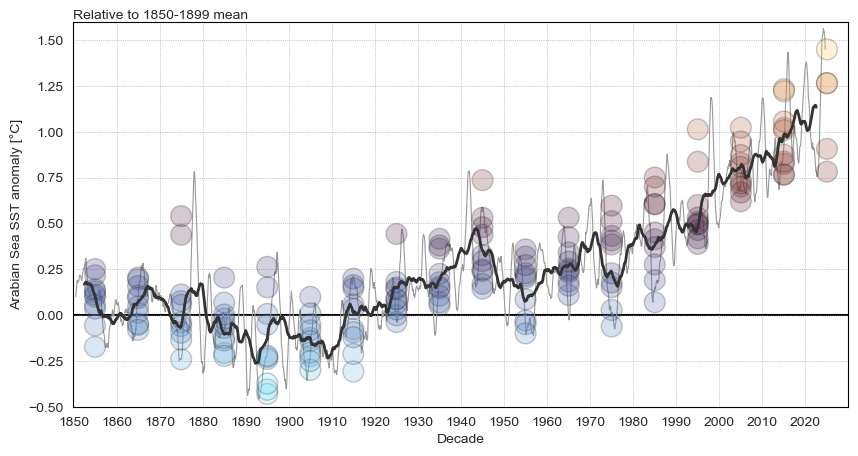

In [6]:
sns.set_style('white', {"axes.edgecolor": "k"})

# set the index for rolling 5-year mean to remove 2.5 years from the beginning and end (10 years = 1 increment)
dndx = np.linspace(-0.25,16.75,2041) 
# for 12-month rolling mean we achieve the same effect by not dropping the nan values
sst_12m = sst_sio.rolling(time=12, center=True).mean()
yndx = np.linspace(-0.5,17,2100) 

# take annual averages of the monthly mean anomalies
dyr_sst = dec_sst.groupby('time.year').mean('time').assign_coords({'decade': ('year', dcde[::12])}) 
# [::12] means every 12th value, from beginning to end of the array

fig, axs = plt.subplots(figsize=(10,5))
# Plotting
axs.axhline(0, color='k')
clrs = colormaps.managua_r
sns.stripplot(ax=axs, x=dyr_sst['decade'].values+5, y=dyr_sst.values, hue=dyr_sst.values, palette=clrs, legend=False, 
              jitter=False, s=15, marker='o', linewidth=1, alpha=0.25) # alpha controls transparency
axs.plot(dndx, roll_sst.values, color='#333', lw=2, zorder=10)
# this index removes 0.5 year from the beginning and end
axs.plot(yndx, sst_12m, color='#999', lw=0.8, zorder=2)
axs.set_ylim((-0.5, 1.6))
axs.set_xlim((-0.5,17.5))
axs.set_xticks(np.arange(-0.5,17))
axs.set_xticklabels(np.arange(1850,2021,10).astype('str'))
axs.set_ylabel('Arabian Sea SST anomaly [°C]')
axs.set_xlabel('Decade')
axs.text(0, 1, 'Relative to 1850-1899 mean', ha='left', va='bottom', transform=axs.transAxes)
for yy in np.arange(-0.5,17):
    axs.axvline(yy, color='#999', ls=':', lw=0.5)
for tt in axs.yaxis.get_majorticklocs():
    axs.axhline(tt, color='#999', ls=':', lw=0.5)
plt.show()

One of the issues you may encounter in plotting time series is inconsistencies in how dates are dealt with in different modules. In this example, we have avoided the problem by using [seaborn.stripplot()](https://seaborn.pydata.org/generated/seaborn.stripplot.html) first. This sets the categories along the *x*-axis at unit intervals, each corresponding to one decade. Other approaches:
- [How matplotlib handles dates](https://matplotlib.org/stable/users/explain/axes/axes_units.html)
- [Axes and cftime: nc-time-axis](https://nc-time-axis.readthedocs.io/en/latest/)

In the next tutorial, we close by illustrating how to use xarray to combine spatial and temporal analyses for trends and regressions.